In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import json
import datetime as dt

In [2]:
updateData = True

In [7]:
ls = [dt.datetime(2020,1,1),dt.datetime(2020,1,3),dt.datetime(2020,1,4),]
ls2 = [dt.datetime(2020,1,2),dt.datetime(2020,1,5)]

pd.DatetimeIndex(ls).join(pd.DatetimeIndex(ls2),how='outer')

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05'],
              dtype='datetime64[ns]', freq=None)

In [11]:
data = pd.read_json('https://www.bing.com/covid/graphdata',lines=True)

df = pd.DataFrame(index=['confirmed','fatal','recovered','date'])
confirmed = pd.DataFrame()
fatal = pd.DataFrame()
recovered = pd.DataFrame()
for country in data.columns:
    countryDf = pd.DataFrame(data.loc[0,country]).set_index('date')
    jointIndex = confirmed.index.join(countryDf.index, how='outer')
    confirmed = confirmed.reindex(jointIndex)
    fatal = fatal.reindex(jointIndex)
    recovered = recovered.reindex(jointIndex)
    confirmed[country] = countryDf['confirmed'].drop_duplicates()
    fatal[country] = countryDf['fatal'].drop_duplicates()
    recovered[country] = countryDf['recovered'].drop_duplicates()


In [17]:
confirmed = pd.DataFrame()
fatal = pd.DataFrame()
recovered = pd.DataFrame()
country='italy'
countryDf = pd.DataFrame(data.loc[0,country]).set_index('date')
jointIndex = confirmed.index.join(countryDf.index)
jointIndex


Index([], dtype='object')

In [18]:
# UPDATE DATA
if updateData:
    data = pd.read_json('https://www.bing.com/covid/graphdata',lines=True)

    df = pd.DataFrame(index=['confirmed','fatal','recovered','date'])
    confirmed = pd.DataFrame()
    fatal = pd.DataFrame()
    recovered = pd.DataFrame()
    for country in data.columns:
        countryDf = pd.DataFrame(data.loc[0,country]).set_index('date')
        jointIndex = confirmed.index.join(countryDf.index,how='outer')
        confirmed = confirmed.reindex(jointIndex)
        fatal = fatal.reindex(jointIndex)
        recovered = recovered.reindex(jointIndex)
        confirmed[country] = countryDf['confirmed'].drop_duplicates()
        fatal[country] = countryDf['fatal'].drop_duplicates()
        recovered[country] = countryDf['recovered'].drop_duplicates()

    # Clean Data
    confirmed.index = pd.to_datetime(confirmed.index)
    fatal.index = pd.to_datetime(fatal.index)
    recovered.index = pd.to_datetime(recovered.index)
    
    regions_index = confirmed.columns[confirmed.columns.str.contains('_')]
    confirmed.drop(regions_index, axis=1, inplace=True)
    fatal.drop(regions_index, axis=1, inplace=True)
    recovered.drop(regions_index, axis=1, inplace=True)
    
    #Sync data
    fatal = fatal.reindex(confirmed.index,).replace(0,np.nan).fillna(method='ffill').fillna(0)
    recovered = recovered.reindex(confirmed.index,).replace(0,np.nan).fillna(method='ffill').fillna(0)
    confirmed = confirmed.replace(0,np.nan).fillna(method='ffill').fillna(0)

    confirmed.to_pickle('confirmed.pkl')
    fatal.to_pickle('fatal.pkl')
    recovered.to_pickle('recovered.pkl')


In [19]:
# GET CACHE DATA
confirmed = pd.read_pickle('confirmed.pkl')
fatal = pd.read_pickle('fatal.pkl')
recovered = pd.read_pickle('recovered.pkl')

In [29]:
x = confirmed['italy']
x[x>=100].index[0]

Timestamp('2020-02-22 00:00:00')

In [5]:
# Calculate active cases
active = confirmed - recovered - fatal

# Top Rankings

In [6]:
confirmed.iloc[-1].sort_values(ascending=False).head(10)

world            378394.0
chinamainland     81093.0
italy             63927.0
unitedstates      43874.0
spain             39673.0
germany           29056.0
iran              23049.0
france            22202.0
southkorea         8961.0
switzerland        8795.0
Name: 2020-03-23 00:00:00, dtype: float64

In [7]:
fatal.cumsum().iloc[-1].sort_values(ascending=False).head(10)

world            151672.0
chinamainland     79717.0
italy             43197.0
iran              13589.0
spain             10716.0
france             3810.0
unitedstates       2106.0
southkorea         1395.0
unitedkingdom      1375.0
netherlands         809.0
Name: 2020-03-23 00:00:00, dtype: float64

# Exploratory

In [8]:
sample = confirmed.loc[:,confirmed.columns != 'world'].cumsum() / 1000
sample = sample.loc[:,sample.iloc[-1] > 0.5]

In [9]:
sample.iloc[-1].describe()

count      87.000000
mean       61.130954
std       351.626366
min         0.522000
25%         1.146500
50%         2.641000
75%         8.044000
max      3228.229000
Name: 2020-03-23 00:00:00, dtype: float64

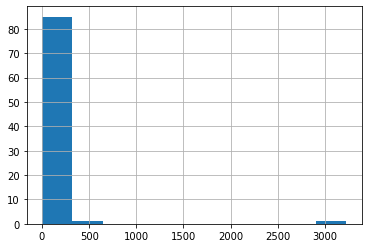

In [10]:
sample.iloc[-1].hist()

# Growth chart

In [21]:
weeklyConfirmed = confirmed.resample('W').max()
#weeklyConfirmed = (confirmed.resample('W').max() / confirmed.resample('W').max().shift(1)) - 1
#weeklyConfirmed = confirmed

zeroindex = (weeklyConfirmed != 0)
syncedConfirmed = pd.DataFrame()

for country in confirmed.columns:
    #find first date
    ar = weeklyConfirmed.index[zeroindex[country]]
    if ar.shape[0] > 0:
        firstDate = ar[0]
        syncedConfirmed[country] = weeklyConfirmed.loc[firstDate:,country].reset_index(drop=True)
#    else:
#        firstDate = weeklyConfirmed.index[0]
        
#    syncedConfirmed[country] = weeklyConfirmed.loc[firstDate:,country]
    

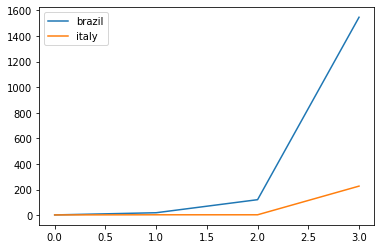

In [22]:
countries_list = [
    'brazil',
    'chinamainland',
    'unitedstates',
    'france',
    'spain',
    'netherlands',
    'singapore',
    'hongkong',
    'italy',
    'southkorea',
]

countries_list = [
    'brazil',
    'italy',
]



# syncedConfirmed[countries_list].to_excel('Chart.xlsx')
syncedConfirmed[countries_list].iloc[:].plot()

In [23]:
sample = weeklyConfirmed / weeklyConfirmed.shift(1) - 1

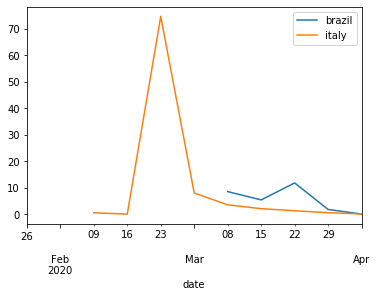

In [24]:
sample[countries_list].plot()

In [30]:
confirmed.resample('W').max()['brazil']

date
2020-01-26       0.0
2020-02-02       0.0
2020-02-09       0.0
2020-02-16       0.0
2020-02-23       0.0
2020-03-01       2.0
2020-03-08      19.0
2020-03-15     121.0
2020-03-22    1546.0
2020-03-29    1629.0
Freq: W-SUN, Name: brazil, dtype: float64

In [13]:
syncedConfirmed[countries_list].to_excel('ConfirmedCases.xlsx')

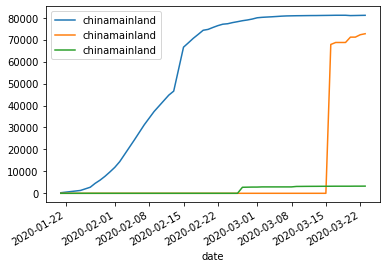

In [14]:
country = 'chinamainland'
pd.DataFrame([confirmed[country],recovered[country],fatal[country],]).T.plot()

In [15]:
pd.Series([np.nan,1,2,np.nan,5]).fillna(method='ffill')

0    NaN
1    1.0
2    2.0
3    2.0
4    5.0
dtype: float64